# 'Seeing' digits: an interpretability dive into MLPs trained on MNIST data

## 1. Overview/goals

Throughout this notebook we will implement:
- Various statistical logs/experiments and visualizations to address things like: why normalization matters and how it affects training.
- Hooks to capture internal activations during training
- dimensionality reduction methods like PCA
- Visualizations: how neurons respond to different inputs\

I don’t claim to be an expert on these tools yet, but part of the point is to learn by doing, document that process, and build a foundation I can use in future projects. Once the MLP is running I’ll upgrade to a CNN (likely in a different notebook) to see what kinds of differences emerge, both in performance and (hopefully) in how the network learns to represent digits.

The broader goal is to build a strong foundation in the interpretability toolkit so I can apply these ideas to current (and future!) projects—like my toy AlphaZero agent, my LLM alignment project (to come!), and possibly some visual experiments with TransformerLens.

## 2. MNIST data

### Section 2: Overview
We will proceed as follows:

**2.1.** Download and batch data (without normalization): the goal of this step is to have a baseline to compare future experiments\
**2.2.** Investigate statistics before training: **Raw input mean**: 0.1307, **Raw input std**: 0.3015. \
We also include some histograms of the raw data to accompany these statistics: there is a lot of white space in these images so we expect big peaks in the hisstograms near 0, and again near 1. We also expect different distributions based on digits (there is less marking for a '1' than for a '0' or '8') so we specialize this approach to individual digits as well. We will use this in the following sections to see if our model does better with certain digits than others. 
> **Visualizations**
>  1) histogram of pixel data for first 1000 training examples
>  2) histogram of pixel data based on digit
>  3) bar chart of mean pixel data per digit
>  4) mean $\pm$ std per digit


### 2.1. MNIST data download/batching

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### 2.2. Some statistics/visualizations

In [16]:
means = []
stds = []

for xs, _ in train_loader:
    xs = xs.view(xs.size(0), -1)
    means.append(xs.mean(dim=1))
    stds.append(xs.std(dim=1))

all_means = torch.cat(means)
all_stds = torch.cat(stds)

print(f'Raw input mean: {all_means.mean():.4f}')
print(f'Raw input std: {all_stds.mean():.4f}')

Raw input mean: 0.1307
Raw input std: 0.3015


#### 2.3. Visualizations

#### First, we visualize the actual pixel data distributions for the first 1000 examples
1) We create a list of all pixel data for the first 1000 images
2) We create a dictionary of lists based on label to see if there is a difference in pixel distributions
3) We plot each of the above to visualize the distributions

In [201]:
# Want to gather some actual data for plotting purposes. 
# 1. We will collect all the pixel data
# 2. We collect pixels data based on digits

all_pixels = []
digit_pixels = {i: [] for i in range(10)}
count = 0

for x, y in train_dataset:
    count += 1
    x = x.view(-1)
    all_pixels.append(x)

    digit_pixels[y].append(x.view(-1))

    if count >= 1000:
        break

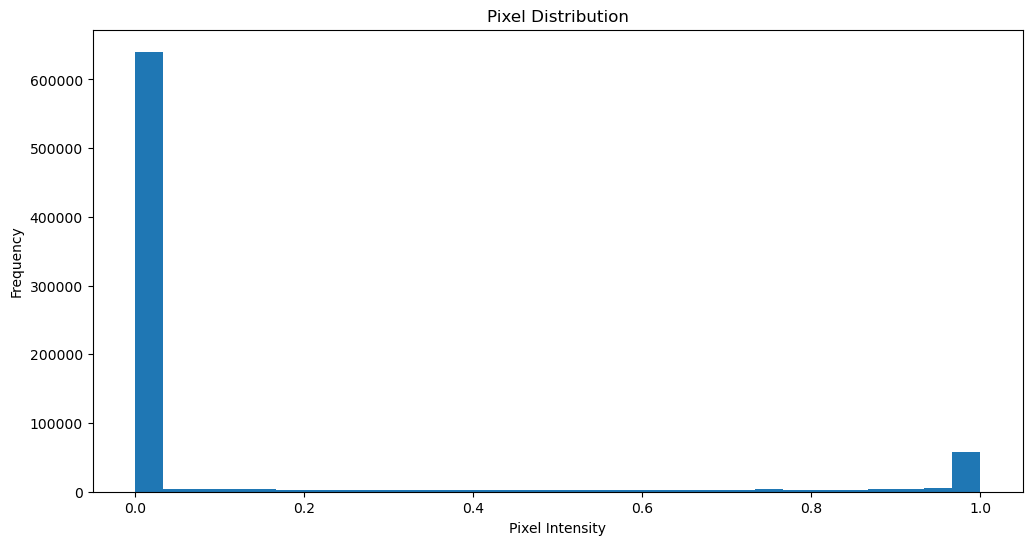

In [203]:
# Take the pixels list and concatenate to create a single 1D tensor
all_pixel_data = torch.cat(all_pixels, dim=0).view(-1)

plt.figure(figsize=(12, 6))
# Plot the data using a histogram with 30 bins
plt.hist(all_pixel_data.numpy(), bins=30)
plt.title("Pixel Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

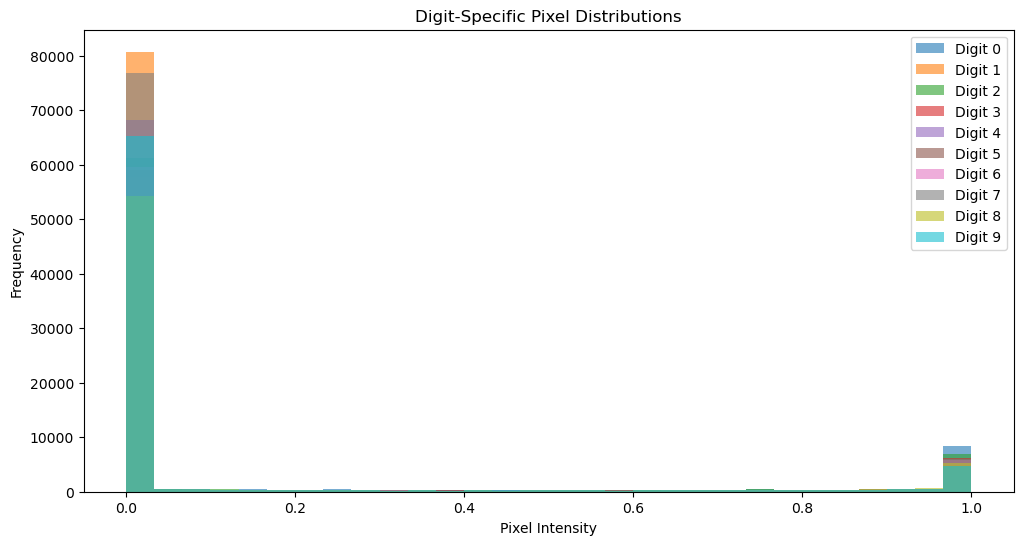

In [205]:
# Now, we do the same but with our digit specific data (we just want to see the differences in pixel distributions... there should be some!)
plt.figure(figsize=(12, 6))
means = []
stds = []
for i in range(10):
    digit_pixel_data = torch.cat(digit_pixels[i], dim=0).view(-1)
    plt.hist(digit_pixel_data.numpy(), bins=30, alpha=0.6, label=f'Digit {i}')
    means.append(digit_pixel_data.mean().item())
    stds.append(digit_pixel_data.std().item())
    
plt.title("Digit-Specific Pixel Distributions")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

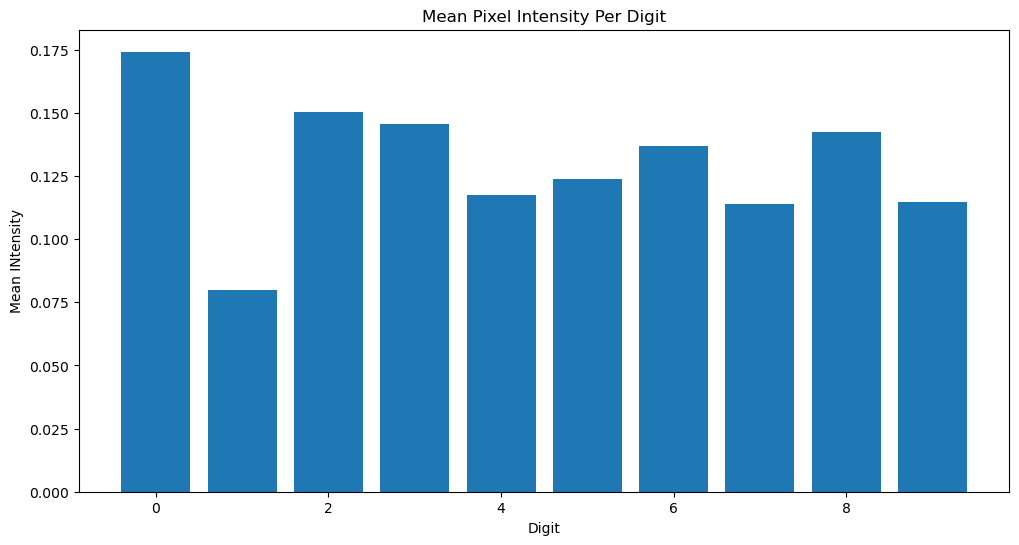

In [207]:
plt.figure(figsize=(12,6))
plt.bar(range(10), means)
plt.title("Mean Pixel Intensity Per Digit")
plt.xlabel("Digit")
plt.ylabel("Mean INtensity")
plt.show()

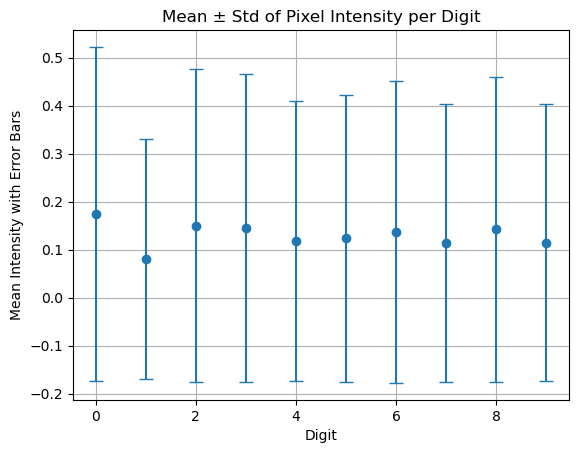

In [209]:
plt.errorbar(range(10), means, yerr=stds, fmt='o', capsize=5)
plt.title("Mean ± Std of Pixel Intensity per Digit")
plt.xlabel("Digit")
plt.ylabel("Mean Intensity with Error Bars")
plt.grid(True)
plt.show()

## 3. Building an interpretable MLP and training our digit classifier (w/o normalization)

### Section 3: Overview
<!--*This sections works on the model without normalizing the data for comparison purposes*\-->
**3.1.** Build model\
**3.2.** Train model and track activations in layer 1 through training (after 20 epochs)\
    - **Loss**: 0.1437, **Accuracy**: 94.94%\
**3.3.** Test model\
    - **Accuracy**: 95.07%\
**3.4.** Train model again with activation tracking throughout the model (layer1, relu1, layer2, relu2, final logits)

### 3.1. Basic (2 hidden layer) MLP with ReLU activation
We attempt to make this as 'interpretable' as possible so we are doing things very simply and making sure we can grab data as we go: i.e. by adding ```self.___#``` in the forward pass we are able to pluck out activations for analysis during training. In the future (below) sections we will do this in a more streamlined way using hooks so we can also track gradients.\
*Note to self: the paper ***Extracting and visualizing hidden activations and computational graphs of PyTorch models with TorchLens*** provides some motivation.*

In [582]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16,10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        self.layer1 = self.linear1(x)
        self.act1 = self.relu1(self.layer1)
        self.layer2 = self.linear2(self.act1)
        self.act2 = self.relu2(self.layer2)
        self.logits = self.output(self.act2)
        return self.logits

### 3.2. Training (visualizing layer 1 activations)

In [586]:
model = MLP()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

activation_log = {'layer1': []}

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    count = 0

    for xs, ys in train_loader:
        yout = model(xs)
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        if count == 0:
            activation_log['layer1'].append(model.act1.detach())
        count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.8941, Accuracy: 43.8550%
Epoch 5 — Loss: 0.3291, Accuracy: 90.6550%
Epoch 10 — Loss: 0.2522, Accuracy: 92.8467%
Epoch 15 — Loss: 0.2056, Accuracy: 94.1867%


#### A helpful function for the next few sections/examples

In [588]:
def activation_viz(layer, list, title):
    plt.figure(figsize=(12, 6))
    for i in list:
        data = layer[i].flatten().numpy()
        plt.hist(data, bins=30, alpha=0.6, label=f'Epoch {i}')
    plt.title(f"{title} Activation Distributions")
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

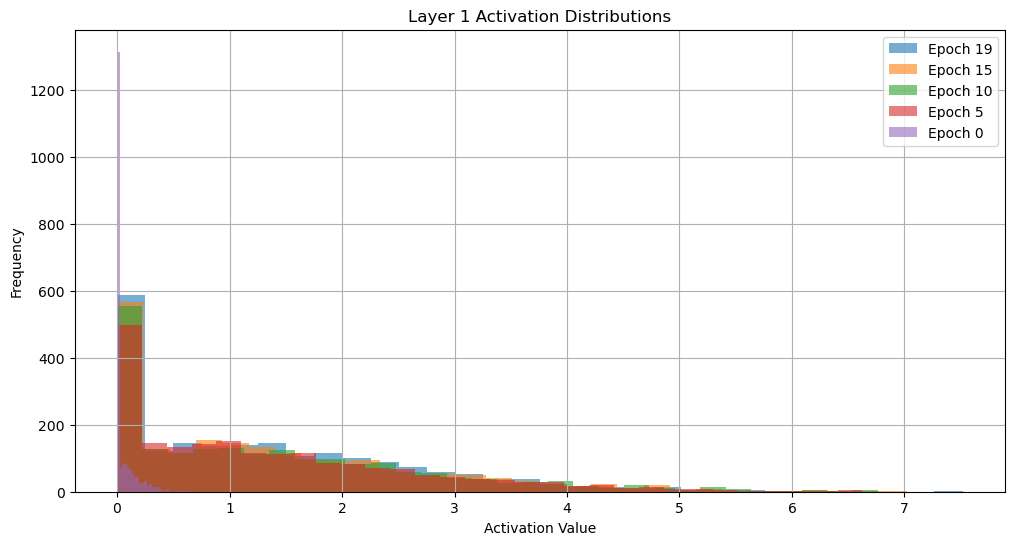

In [605]:
epochs_to_plot = [0 , 5, 10, 15, 19]

activation_viz(activation_log['layer1'], reversed(epochs_to_plot), 'Layer 1')

#### Quick thoughts
Even in the first layer, we see activations quickly spreading out — the histogram fanning out after just a few training steps - I reversed the epoch order here to make this more apparent. While the model still reaches decent accuracy on raw data (and test data), these unnormalized activations suggest poor calibration which would likely cause much more dramatic failure in deeper models. 

In short: non-normalized inputs lead to increasingly extreme activations, layer after layer. This fanning out is a recipe for vanishing or exploding gradients in deeper nets — and often means less stable learning overall.

Below, we’ll compare this to the normalized version, where activations are (hopefully :fingerscrossed) more compact.

### 3.3. Testing the model

In [608]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for xs, ys in test_loader:
        xs = xs.view(xs.size(0), -1)
        yout = model(xs)
        preds = torch.argmax(yout, dim=1)
        correct += (preds == ys).sum().item()
        total += ys.size(0)

print(f"Test Accuracy: {(correct / total)*100:.4f}%")

Test Accuracy: 94.6500%


### 3.4. Tracking all activations

In [610]:
from collections import defaultdict

model = MLP()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 20

activation_log = defaultdict(list)

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    count = 0

    for xs, ys in train_loader:
        yout = model(xs)
        loss = loss_fn(yout, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

        if count == 0:
            activation_log['layer1'].append(model.layer1.detach().flatten())
            activation_log['act1'].append(model.act1.detach().flatten())
            activation_log['layer2'].append(model.layer2.detach().flatten())
            activation_log['act2'].append(model.act2.detach().flatten())
            activation_log['logits'].append(model.logits.detach().flatten())
        count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")

Epoch 0 — Loss: 1.8421, Accuracy: 41.0017%
Epoch 5 — Loss: 0.3151, Accuracy: 91.0200%
Epoch 10 — Loss: 0.2457, Accuracy: 92.9283%
Epoch 15 — Loss: 0.2012, Accuracy: 94.2417%


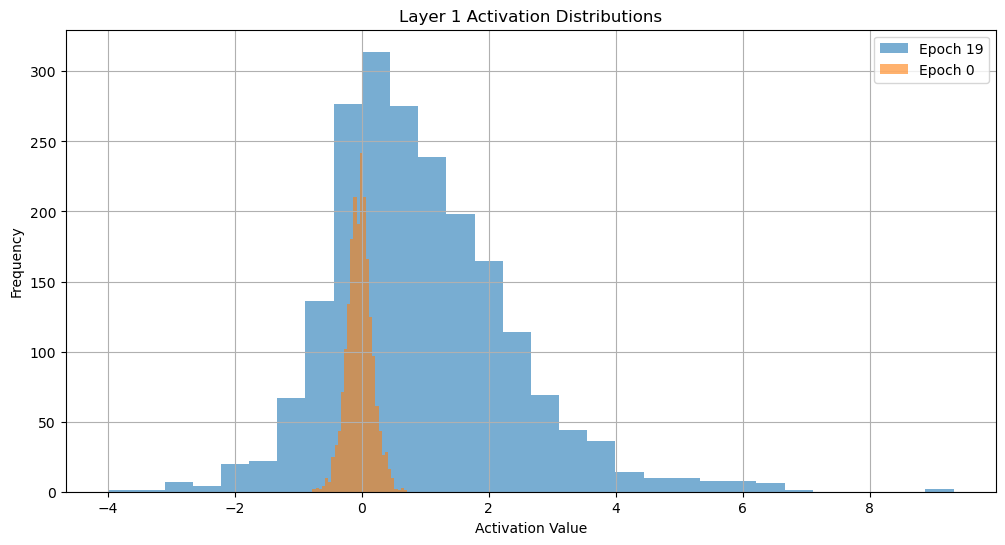

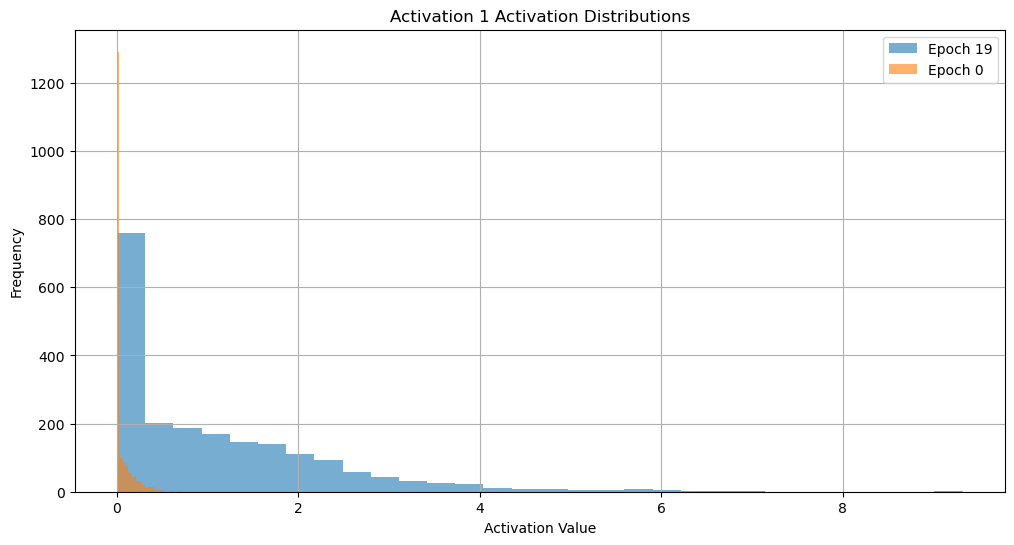

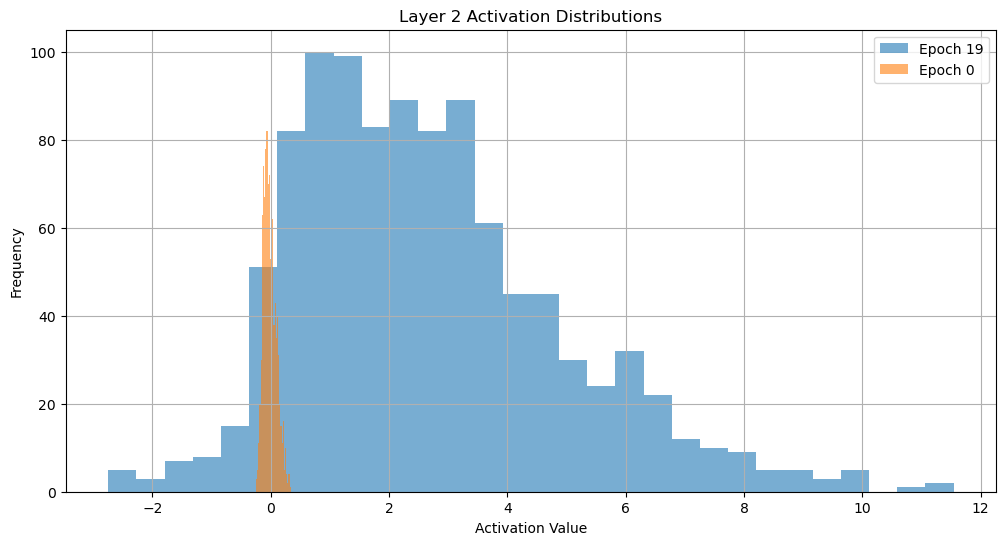

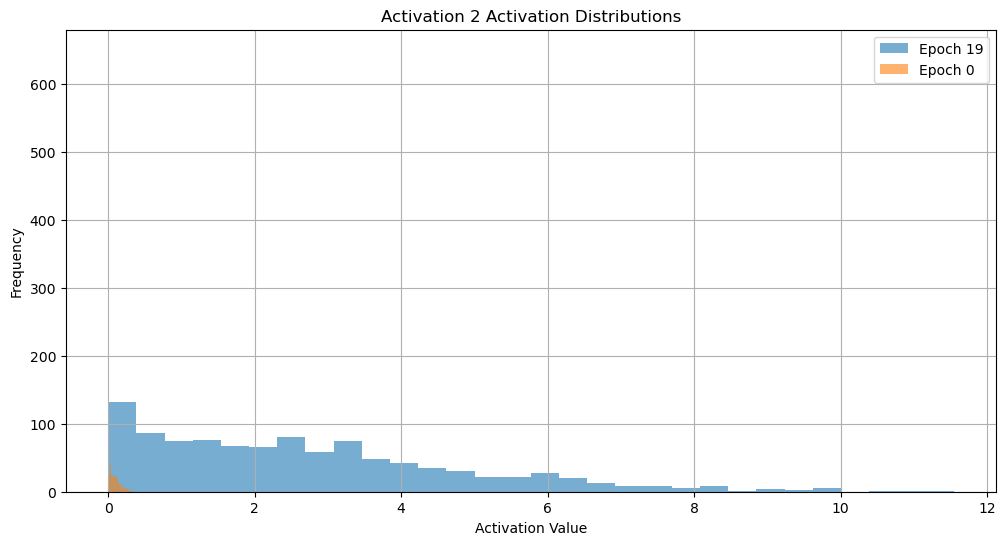

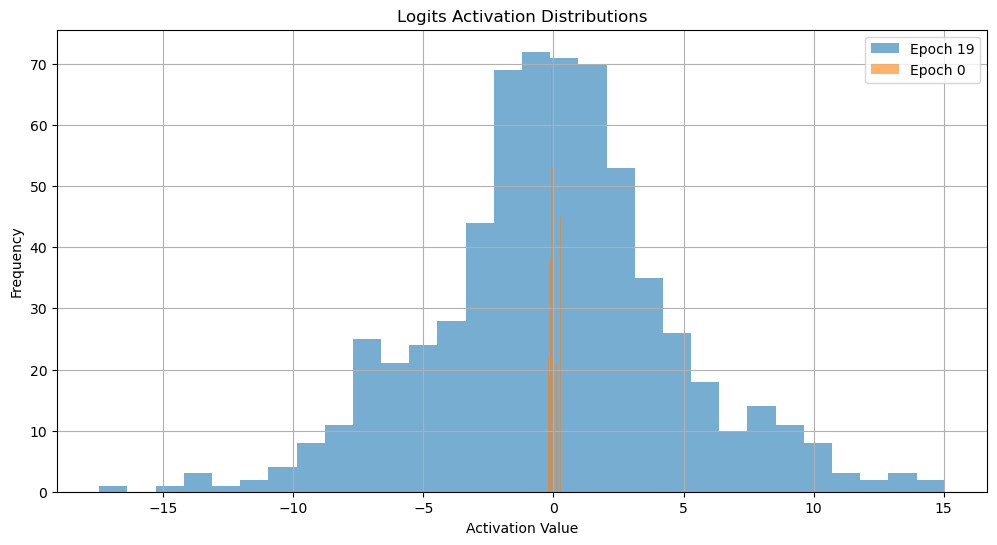

In [615]:
epochs_to_plot = [19,0]
activation_viz(activation_log['layer1'], epochs_to_plot, "Layer 1")
activation_viz(activation_log['act1'], epochs_to_plot, "Activation 1")
activation_viz(activation_log['layer2'], epochs_to_plot, "Layer 2")
activation_viz(activation_log['act2'], epochs_to_plot, "Activation 2")
activation_viz(activation_log['logits'], epochs_to_plot, "Logits")

### 3.5. Further reflections

Above we analyzed the distribution of activations across the entire forward pass, from the first hidden layer to the final logits. To highlight how the model’s internal representations evolve, we compare only the first and final training epochs, which makes the change in distribution especially clear.

So again, even though we achieve reasonable performance on the test set the internal activations show how unstable the training process is.

Before moving on to normalization, let’s ask a couple more questions:

> 1) What about neuron death?  
> 2) What happens when we focus on individual output neurons?

The latter question should help us determine if this is a global issue (affecting all digits) or if it is really a local issue (affecting some classes more than others). We are drawn to this question because we did see some differences in the distribution across classes from section 2. 

### 3.6. Where do we fail!? 
Before moving on, let's just quickly look at some of the examples where our model fails.

In [803]:
correct = 0
total = 0

failures = []

with torch.no_grad():
    for img, y in test_dataset:
        total += 1
        x = img.view(-1, 28*28)
        yout = model(x)
        pred = torch.argmax(yout, dim=1)
        if pred == y:
            correct += 1
        else:
            failures.append((img, y, pred))

print(f'The model acheives {correct/total * 100: .2f}% accuracy on the test set... below we see some failures in the predictions')

The model acheives  94.84% accuracy on the test set... below we see some failures in the predictions


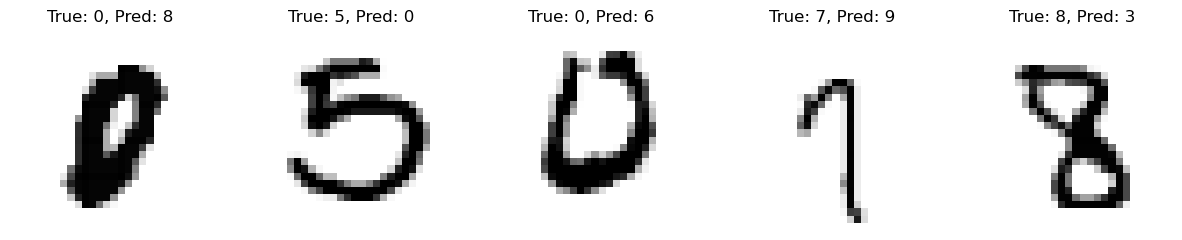

In [801]:
import matplotlib.pyplot as plt

ind = torch.randint(0, len(failures), (5,))

fig, axes = plt.subplots(1, 5, figsize=(15,3))
for ax, i in zip(axes, ind):
    img, label, pred = failures[i.item()]
    ax.imshow(img.squeeze(), cmap='gray_r')
    ax.set_title(f'True: {label}, Pred: {pred.item()}')
    ax.axis('off')
plt.show()

#### Thoughts:
We can see that this is not great! In previous MNIST experiments (before the creation of this notebook) the failures we saw were a little more understandable. We hope the models predictions improve as we fine tune it a bit in future notebooks. 

## 4. Adding hooks, tracking gradients, and analyzing death rates

### Section 4 Overview:


### 4.1. The MLP

In [806]:
import torch 
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28,32)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(32,16)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(16,10)

    def forward(self, x):
        x1 = self.linear1(x)
        x2 = self.act1(x1)
        x3 = self.linear2(x2)
        x4 = self.act2(x3)
        logits = self.output(x4)
        return logits

## 5. Same Model: this time with normalized data!

## 6. Reflections + future directions